In [3]:
from __future__ import print_function

from itertools import combinations, permutations
import logging

import networkx as nx

import numpy as np

import matplotlib.pyplot as plt

_logger = logging.getLogger(__name__)

In [4]:
def _create_complete_graph(node_ids):
    """Create a complete graph from the list of node ids.
    Args:
        node_ids: a list of node ids
    Returns:
        An undirected graph (as a networkx.Graph)
    """
    g = nx.Graph()
    g.add_nodes_from(node_ids)
    for (i, j) in combinations(node_ids, 2):
        g.add_edge(i, j)
    return g

def estimate_skeleton(indep_test_func, data_matrix, alpha, **kwargs):
    """Estimate a skeleton graph from the statistis information.
    Args:
        indep_test_func: the function name for a conditional
            independency test.
        data_matrix: data (as a numpy array).
        alpha: the significance level.
        kwargs:
            'max_reach': maximum value of l (see the code).  The
                value depends on the underlying distribution.
            'method': if 'stable' given, use stable-PC algorithm
                (see [Colombo2014]).
            'init_graph': initial structure of skeleton graph
                (as a networkx.Graph). If not specified,
                a complete graph is used.
            other parameters may be passed depending on the
                indep_test_func()s.
    Returns:
        g: a skeleton graph (as a networkx.Graph).
        sep_set: a separation set (as an 2D-array of set()).
    [Colombo2014] Diego Colombo and Marloes H Maathuis. Order-independent
    constraint-based causal structure learning. In The Journal of Machine
    Learning Research, Vol. 15, pp. 3741-3782, 2014.
    """

    def method_stable(kwargs):
        return ('method' in kwargs) and kwargs['method'] == "stable"

    node_ids = range(data_matrix.shape[1])
    node_size = data_matrix.shape[1]
    sep_set = [[set() for i in range(node_size)] for j in range(node_size)]
    if 'init_graph' in kwargs:
        g = kwargs['init_graph']
        if not isinstance(g, nx.Graph):
            raise ValueError
        elif not g.number_of_nodes() == len(node_ids):
            raise ValueError('init_graph not matching data_matrix shape')
        for (i, j) in combinations(node_ids, 2):
            if not g.has_edge(i, j):
                sep_set[i][j] = None
                sep_set[j][i] = None
    else:
        g = _create_complete_graph(node_ids)

    l = 0
    while True:
        cont = False
        remove_edges = []
        for (i, j) in permutations(node_ids, 2):
            adj_i = list(g.neighbors(i))
            if j not in adj_i:
                continue
            else:
                adj_i.remove(j)
            if len(adj_i) >= l:
                _logger.debug('testing %s and %s' % (i,j))
                _logger.debug('neighbors of %s are %s' % (i, str(adj_i)))
                if len(adj_i) < l:
                    continue
                for k in combinations(adj_i, l):
                    _logger.debug('indep prob of %s and %s with subset %s'
                                  % (i, j, str(k)))
                    p_val = indep_test_func(data_matrix, i, j, set(k),
                                            **kwargs)
                    _logger.debug('p_val is %s' % str(p_val))
                    if p_val > alpha:
                        if g.has_edge(i, j):
                            _logger.debug('p: remove edge (%s, %s)' % (i, j))
                            if method_stable(kwargs):
                                remove_edges.append((i, j))
                            else:
                                g.remove_edge(i, j)
                        sep_set[i][j] |= set(k)
                        sep_set[j][i] |= set(k)
                        break
                cont = True
        l += 1
        if method_stable(kwargs):
            g.remove_edges_from(remove_edges)
        if cont is False:
            break
        if ('max_reach' in kwargs) and (l > kwargs['max_reach']):
            break

    return (g, sep_set)

def estimate_cpdag(skel_graph, sep_set):
    """Estimate a CPDAG from the skeleton graph and separation sets
    returned by the estimate_skeleton() function.
    Args:
        skel_graph: A skeleton graph (an undirected networkx.Graph).
        sep_set: An 2D-array of separation set.
            The contents look like something like below.
                sep_set[i][j] = set([k, l, m])
    Returns:
        An estimated DAG.
    """
    dag = skel_graph.to_directed()
    node_ids = skel_graph.nodes()
    for (i, j) in combinations(node_ids, 2):
        adj_i = set(dag.successors(i))
        if j in adj_i:
            continue
        adj_j = set(dag.successors(j))
        if i in adj_j:
            continue
        if sep_set[i][j] is None:
            continue
        common_k = adj_i & adj_j
        for k in common_k:
            if k not in sep_set[i][j]:
                if dag.has_edge(k, i):
                    _logger.debug('S: remove edge (%s, %s)' % (k, i))
                    dag.remove_edge(k, i)
                if dag.has_edge(k, j):
                    _logger.debug('S: remove edge (%s, %s)' % (k, j))
                    dag.remove_edge(k, j)

    def _has_both_edges(dag, i, j):
        return dag.has_edge(i, j) and dag.has_edge(j, i)

    def _has_any_edge(dag, i, j):
        return dag.has_edge(i, j) or dag.has_edge(j, i)

    def _has_one_edge(dag, i, j):
        return ((dag.has_edge(i, j) and (not dag.has_edge(j, i))) or
                (not dag.has_edge(i, j)) and dag.has_edge(j, i))

    def _has_no_edge(dag, i, j):
        return (not dag.has_edge(i, j)) and (not dag.has_edge(j, i))

    # For all the combination of nodes i and j, apply the following
    # rules.
    old_dag = dag.copy()
    while True:
        for (i, j) in combinations(node_ids, 2):
            # Rule 1: Orient i-j into i->j whenever there is an arrow k->i
            # such that k and j are nonadjacent.
            #
            # Check if i-j.
            if _has_both_edges(dag, i, j):
                # Look all the predecessors of i.
                for k in dag.predecessors(i):
                    # Skip if there is an arrow i->k.
                    if dag.has_edge(i, k):
                        continue
                    # Skip if k and j are adjacent.
                    if _has_any_edge(dag, k, j):
                        continue
                    # Make i-j into i->j
                    _logger.debug('R1: remove edge (%s, %s)' % (j, i))
                    dag.remove_edge(j, i)
                    break

            # Rule 2: Orient i-j into i->j whenever there is a chain
            # i->k->j.
            #
            # Check if i-j.
            if _has_both_edges(dag, i, j):
                # Find nodes k where k is i->k.
                succs_i = set()
                for k in dag.successors(i):
                    if not dag.has_edge(k, i):
                        succs_i.add(k)
                # Find nodes j where j is k->j.
                preds_j = set()
                for k in dag.predecessors(j):
                    if not dag.has_edge(j, k):
                        preds_j.add(k)
                # Check if there is any node k where i->k->j.
                if len(succs_i & preds_j) > 0:
                    # Make i-j into i->j
                    _logger.debug('R2: remove edge (%s, %s)' % (j, i))
                    dag.remove_edge(j, i)

            # Rule 3: Orient i-j into i->j whenever there are two chains
            # i-k->j and i-l->j such that k and l are nonadjacent.
            #
            # Check if i-j.
            if _has_both_edges(dag, i, j):
                # Find nodes k where i-k.
                adj_i = set()
                for k in dag.successors(i):
                    if dag.has_edge(k, i):
                        adj_i.add(k)
                # For all the pairs of nodes in adj_i,
                for (k, l) in combinations(adj_i, 2):
                    # Skip if k and l are adjacent.
                    if _has_any_edge(dag, k, l):
                        continue
                    # Skip if not k->j.
                    if dag.has_edge(j, k) or (not dag.has_edge(k, j)):
                        continue
                    # Skip if not l->j.
                    if dag.has_edge(j, l) or (not dag.has_edge(l, j)):
                        continue
                    # Make i-j into i->j.
                    _logger.debug('R3: remove edge (%s, %s)' % (j, i))
                    dag.remove_edge(j, i)
                    break

            # Rule 4: Orient i-j into i->j whenever there are two chains
            # i-k->l and k->l->j such that k and j are nonadjacent.
            #
            # However, this rule is not necessary when the PC-algorithm
            # is used to estimate a DAG.

        if nx.is_isomorphic(dag, old_dag):
            break
        old_dag = dag.copy()

    return dag

**Orienting the egdes of my PCBN from given structure and adjacency matrix**

In [5]:
s1 = [set(),set([4]),set([4,6]),set([2]),set(),set(),set([4,5]),set([7])]
s2 = [set([4]),set(),set(),set(),set([3]),set([4]),set([3]),set()]
s3 = [set([4,6]),set(),set(),set(),set([2]),set([4,5]),set([6]),set([3,8])]
s4 = [set([2]),set(),set(),set(),set([3]),set([2,3]),set([6]),set()]
s5 = [set(),set([3]),set([2]),set([3]),set(),set([1,4]),set(),set([7])]
s6 = [set(),set([4]),set([4,5]),set([2,3]),set([1,4]),set(),set(),set()]
s7 = [set([4,5]),set([3]),set([6]),set([6]),set(),set(),set(),set()]
s8 = [set([7]),set(),set([5]),set(),set([7]),set(),set(),set()]

In [6]:
sepset = [s1,s2,s3,s4,s5,s6,s7,s8]

In [28]:
G = nx.Graph()

In [29]:
G.add_nodes_from([i for i in range(8)])

Add edges as determined from my KCITPC Algorithm run previously.

In [30]:
edges = [(5,6),(5,0),(5,3),(6,0),(0,3),(6,4),(0,4),(0,7),(3,7),(3,1),(3,2),(4,7),(4,2),(7,2),(7,1),(1,2)]

In [31]:
G.add_edges_from(edges)

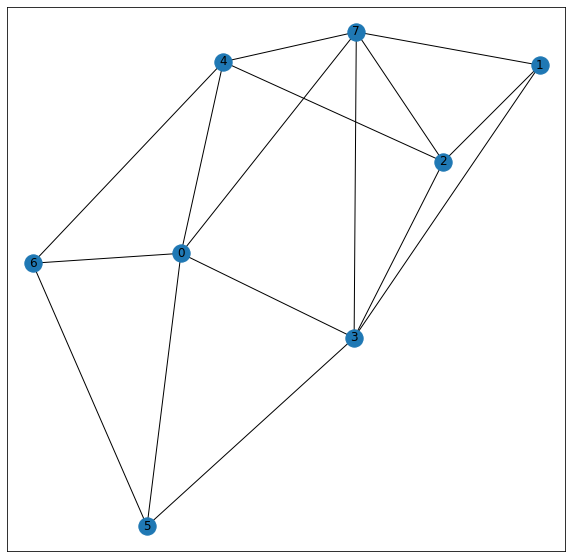

In [32]:
plt.figure(figsize=(10,10))
nx.draw_networkx(G)

In [33]:
f = estimate_cpdag(G,sepset)

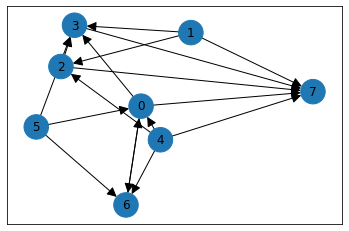

In [38]:
nx.draw_networkx(f,arrowsize=20,node_size=[600]*8)